# Cadeias logísticas (Supply Chain)
Transporte de produtos entre fábricas, armazéns e lojas. Aplicar fluxo em redes com custo (mínimo custo de fluxo).

In [1]:
# import kagglehub
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random

In [2]:
# data = pd.read_excel("sup_chain_data.xlsx")
# data
xls = pd.ExcelFile("sup_chain_data.xlsx")
sheet_names = xls.sheet_names
data = {sheet: xls.parse(sheet) for sheet in sheet_names}
sample_data = {sheet: df.head() for sheet, df in data.items()}
sample_data



{'OrderList':        Order ID Order Date Origin Port Carrier  TPT Service Level  \
 0  1.447296e+09 2013-05-26      PORT09   V44_3    1           CRF   
 1  1.447158e+09 2013-05-26      PORT09   V44_3    1           CRF   
 2  1.447139e+09 2013-05-26      PORT09   V44_3    1           CRF   
 3  1.447364e+09 2013-05-26      PORT09   V44_3    1           CRF   
 4  1.447364e+09 2013-05-26      PORT09   V44_3    1           CRF   
 
    Ship ahead day count  Ship Late Day count   Customer  Product ID  \
 0                     3                    0  V55555_53     1700106   
 1                     3                    0  V55555_53     1700106   
 2                     3                    0  V55555_53     1700106   
 3                     3                    0  V55555_53     1700106   
 4                     3                    0  V55555_53     1700106   
 
   Plant Code Destination Port  Unit quantity  Weight  
 0    PLANT16           PORT09            808   14.30  
 1    PLANT16      

In [3]:
sheet_names

['OrderList',
 'FreightRates',
 'WhCosts',
 'WhCapacities',
 'ProductsPerPlant',
 'VmiCustomers',
 'PlantPorts']

In [4]:
data['OrderList']

,Order ID,Order Date,Origin Port,Carrier,TPT,Service Level,Ship ahead day count,Ship Late Day count,Customer,Product ID,Plant Code,Destination Port,Unit quantity,Weight
0,1.447296e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,808,14.300000
1,1.447158e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,3188,87.940000
2,1.447139e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,2331,61.200000
3,1.447364e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,847,16.160000
4,1.447364e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,2163,52.340000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9210,1.447305e+09,2013-05-26,PORT04,V444_1,1,DTD,5,0,V55555555555555_8,1683388,PLANT03,PORT09,339,2.354118
9211,1.447319e+09,2013-05-26,PORT04,V444_1,1,DTD,5,0,V55555555555555_8,1683388,PLANT03,PORT09,339,2.354118
9212,1.447322e+09,2013-05-26,PORT04,V444_1,1,DTD,5,0,V55555555555555_8,1683388,PLANT03,PORT09,245,0.294265
9213,1.447145e+09,2013-05-26,PORT04,V444_1,1,DTD,5,0,V55555555555555_8,1683430,PLANT03,PORT09,278,2.480000


In [5]:
data['PlantPorts']

,Plant Code,Port
0,PLANT01,PORT01
1,PLANT01,PORT02
2,PLANT02,PORT03
3,PLANT03,PORT04
4,PLANT04,PORT05
5,PLANT05,PORT06
6,PLANT06,PORT06
7,PLANT07,PORT01
8,PLANT07,PORT02
9,PLANT08,PORT04


In [6]:
# Criando vetor de arestas, com o armazem sendo i e o porto sendo j, (i,j)\in A
df = data['PlantPorts']

plant_map = {name: i+1 for i, name in enumerate(df['Plant Code'].unique())}
port_map = {name: i+1 for i, name in enumerate(df['Port'].unique())}

A = [(plant_map[plant], port_map[port]) for plant, port in zip(df['Plant Code'], df['Port'])]
A


[(1, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 6),
 (6, 6),
 (7, 1),
 (7, 2),
 (8, 4),
 (9, 4),
 (10, 1),
 (10, 2),
 (11, 4),
 (12, 4),
 (13, 4),
 (14, 7),
 (15, 8),
 (16, 9),
 (17, 10),
 (18, 11),
 (19, 4)]

In [7]:
data['ProductsPerPlant']

,Plant Code,Product ID
0,PLANT15,1698815
1,PLANT17,1664419
2,PLANT17,1664426
3,PLANT17,1672826
4,PLANT17,1674916
...,...,...
2031,PLANT04,1699951
2032,PLANT04,1699952
2033,PLANT04,1699953
2034,PLANT04,1699954


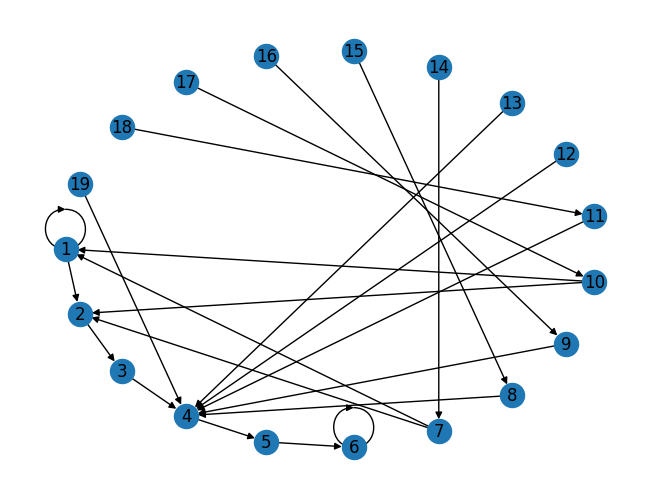

In [8]:
G1 = nx.DiGraph()
G1.add_edges_from(A)

pos1 = nx.planar_layout(G1)
nx.draw_shell(G1, with_labels=True)
# nx.draw_networkx_edge_labels(G1, pos1, edge_labels=c)
plt.show()

In [9]:
import string

# Supondo que o DataFrame esteja em data['PlantPorts']
df = data['PlantPorts']

# Mapeamento dos plants para números (começando de 1)
plant_map = {name: i+1 for i, name in enumerate(df['Plant Code'].unique())}

# Mapeamento dos ports para letras (A, B, C, ...)
letters = string.ascii_uppercase  # 'A' a 'Z'
port_map = {name: letters[i] for i, name in enumerate(df['Port'].unique())}

# Criar as tuplas com os valores mapeados
A = [(plant_map[plant], port_map[port]) for plant, port in zip(df['Plant Code'], df['Port'])]
A


[(1, 'A'),
 (1, 'B'),
 (2, 'C'),
 (3, 'D'),
 (4, 'E'),
 (5, 'F'),
 (6, 'F'),
 (7, 'A'),
 (7, 'B'),
 (8, 'D'),
 (9, 'D'),
 (10, 'A'),
 (10, 'B'),
 (11, 'D'),
 (12, 'D'),
 (13, 'D'),
 (14, 'G'),
 (15, 'H'),
 (16, 'I'),
 (17, 'J'),
 (18, 'K'),
 (19, 'D')]

In [10]:
new_df = pd.read_csv('dataco.csv', encoding='latin-1')
new_df.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [11]:
# Descrição do data frame
desc_df = pd.read_csv('descdataco.csv', encoding='latin-1')
desc_df

,FIELDS,DESCRIPTION
0,Type,: Type of transaction made
1,Days for shipping (real),: Actual shipping days of the purchased product
2,Days for shipment (scheduled),: Days of scheduled delivery of the purchased...
3,Benefit per order,: Earnings per order placed
4,Sales per customer,: Total sales per customer made per customer
5,Delivery Status,: Delivery status of orders: Advance shipping...
6,Late_delivery_risk,: Categorical variable that indicates if send...
7,Category Id,: Product category code
8,Category Name,: Description of the product category
9,Customer City,: City where the customer made the purchase


In [12]:
new_df = new_df.drop(['Product Image', 'Product Description', 'Order Zipcode', 'Product Status', 'Customer Password', 'Customer Email'],axis=1)
new_df.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Profit Per Order,Order Region,Order State,Order Status,Product Card Id,Product Category Id,Product Name,Product Price,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,91.250000,Southeast Asia,Java Occidental,COMPLETE,1360,73,Smart watch,327.75,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,-249.089996,South Asia,Rajastán,PENDING,1360,73,Smart watch,327.75,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,-247.779999,South Asia,Rajastán,CLOSED,1360,73,Smart watch,327.75,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,22.860001,Oceania,Queensland,COMPLETE,1360,73,Smart watch,327.75,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,134.210007,Oceania,Queensland,PENDING_PAYMENT,1360,73,Smart watch,327.75,1/15/2018 11:24,Standard Class


In [13]:
new_df['order date (DateOrders)']

0         1/31/2018 22:56
1         1/13/2018 12:27
2         1/13/2018 12:06
3         1/13/2018 11:45
4         1/13/2018 11:24
               ...       
180514     1/16/2016 3:40
180515     1/16/2016 1:34
180516    1/15/2016 21:00
180517    1/15/2016 20:18
180518    1/15/2016 18:54
Name: order date (DateOrders), Length: 180519, dtype: object

Os dados sobre o pedido está na forma de string "data hora", então criamos uma nova coluna no Data Frame contendo apenas a data

In [14]:
# A nova data é do tipo, (Ano-Mes-Dia)
new_df['order date (DateOrders)'] = pd.to_datetime(new_df['order date (DateOrders)'])
new_df['Date'] = new_df['order date (DateOrders)'].dt.date
new_df['Date']

0         2018-01-31
1         2018-01-13
2         2018-01-13
3         2018-01-13
4         2018-01-13
             ...    
180514    2016-01-16
180515    2016-01-16
180516    2016-01-15
180517    2016-01-15
180518    2016-01-15
Name: Date, Length: 180519, dtype: object

Iniciamos filtrando a data para saber todas operações que foram realizadas naquele dia.

In [15]:
same_date = new_df[new_df['Date'] == pd.to_datetime('2016-1-20').date()]
same_date.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Region,Order State,Order Status,Product Card Id,Product Category Id,Product Name,Product Price,shipping date (DateOrders),Shipping Mode,Date
2206,DEBIT,5,4,22.900000,49.790001,Late delivery,1,17,Cleats,Quincy,...,Eastern Asia,Hyogo,COMPLETE,365,17,Perfect Fitness Perfect Rip Deck,59.990002,1/25/2016 20:07,Standard Class,2016-01-20
2274,DEBIT,6,4,19.200001,39.990002,Late delivery,1,29,Shop By Sport,Long Beach,...,Southeast Asia,Yakarta,COMPLETE,627,29,Under Armour Girls' Toddler Spine Surge Runni,39.990002,1/26/2016 4:43,Standard Class,2016-01-20
2321,DEBIT,5,4,12.520000,40.000000,Late delivery,1,24,Women's Apparel,Hialeah,...,South Asia,Chittagong,COMPLETE,502,24,Nike Men's Dri-FIT Victory Golf Polo,50.000000,1/25/2016 21:53,Standard Class,2016-01-20
4300,DEBIT,4,4,22.500000,44.990002,Shipping on time,0,17,Cleats,Mchenry,...,Southeast Asia,Ciudad Ho Chi Minh,ON_HOLD,365,17,Perfect Fitness Perfect Rip Deck,59.990002,1/24/2016 14:31,Standard Class,2016-01-20
4315,DEBIT,4,4,-37.500000,299.980011,Shipping on time,0,43,Camping & Hiking,Mchenry,...,Southeast Asia,Ciudad Ho Chi Minh,ON_HOLD,957,43,Diamondback Women's Serene Classic Comfort Bi,299.980011,1/24/2016 14:31,Standard Class,2016-01-20


In [16]:
# São exibidos os cinco primeiros na lista
A = list(zip(same_date['Customer Country'], same_date['Order Country']))
A[:5]

[('EE. UU.', 'Japón'),
 ('EE. UU.', 'Indonesia'),
 ('EE. UU.', 'Bangladés'),
 ('EE. UU.', 'Vietnam'),
 ('EE. UU.', 'Vietnam')]

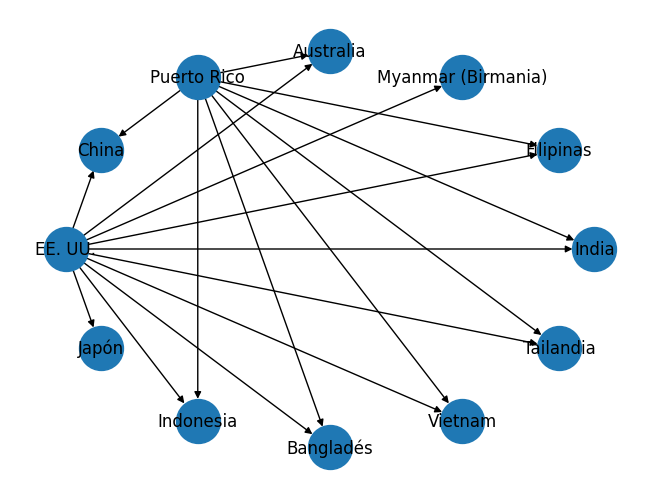

In [17]:
G1 = nx.DiGraph()
G1.add_edges_from(A)

pos1 = nx.planar_layout(G1)
nx.draw_shell(G1, with_labels=True, node_size=1000)
plt.show()

In [18]:
# Ao invés de utilizar o nome do país vamos utilizar um valor numérico
countries = pd.unique(same_date[['Customer Country', 'Order Country']].values.ravel())
mapping = {pais: i+1 for i, pais in enumerate(countries)}
A_num = list(zip(
    same_date['Customer Country'].map(mapping),
    same_date['Order Country'].map(mapping)
))
A_num[:5]

[(1, 2), (1, 3), (1, 4), (1, 5), (1, 5)]

In [19]:
df_mapping = pd.DataFrame(list(mapping.items()), columns=['País', 'Código'])
df_mapping

,País,Código
0,EE. UU.,1
1,Japón,2
2,Indonesia,3
3,Bangladés,4
4,Vietnam,5
5,Tailandia,6
6,India,7
7,Filipinas,8
8,Myanmar (Birmania),9
9,Australia,10


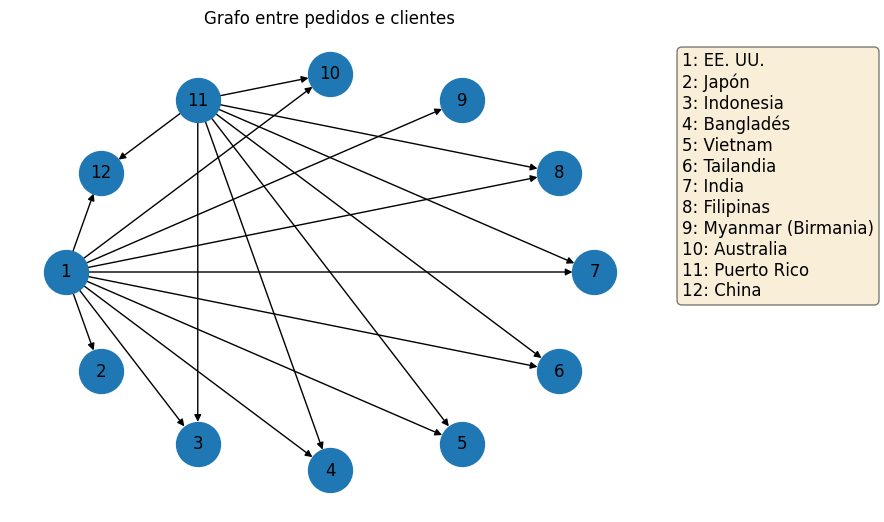

In [20]:
# G2 = nx.DiGraph()
G2 = nx.DiGraph()
G2.add_edges_from(A_num)

pos2 = nx.planar_layout(G2)
nx.draw_shell(G2, with_labels=True, node_size=1000)


legend_text = "\n".join([f"{row['Código']}: {row['País']}" for _, row in df_mapping.sort_values('Código').iterrows()])
plt.text(1.05, 0.7, legend_text, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='center', bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
plt.title("Grafo entre pedidos e clientes")
plt.show()

In [21]:
same_date.columns.tolist()

['Type',
 'Days for shipping (real)',
 'Days for shipment (scheduled)',
 'Benefit per order',
 'Sales per customer',
 'Delivery Status',
 'Late_delivery_risk',
 'Category Id',
 'Category Name',
 'Customer City',
 'Customer Country',
 'Customer Fname',
 'Customer Id',
 'Customer Lname',
 'Customer Segment',
 'Customer State',
 'Customer Street',
 'Customer Zipcode',
 'Department Id',
 'Department Name',
 'Latitude',
 'Longitude',
 'Market',
 'Order City',
 'Order Country',
 'Order Customer Id',
 'order date (DateOrders)',
 'Order Id',
 'Order Item Cardprod Id',
 'Order Item Discount',
 'Order Item Discount Rate',
 'Order Item Id',
 'Order Item Product Price',
 'Order Item Profit Ratio',
 'Order Item Quantity',
 'Sales',
 'Order Item Total',
 'Order Profit Per Order',
 'Order Region',
 'Order State',
 'Order Status',
 'Product Card Id',
 'Product Category Id',
 'Product Name',
 'Product Price',
 'shipping date (DateOrders)',
 'Shipping Mode',
 'Date']

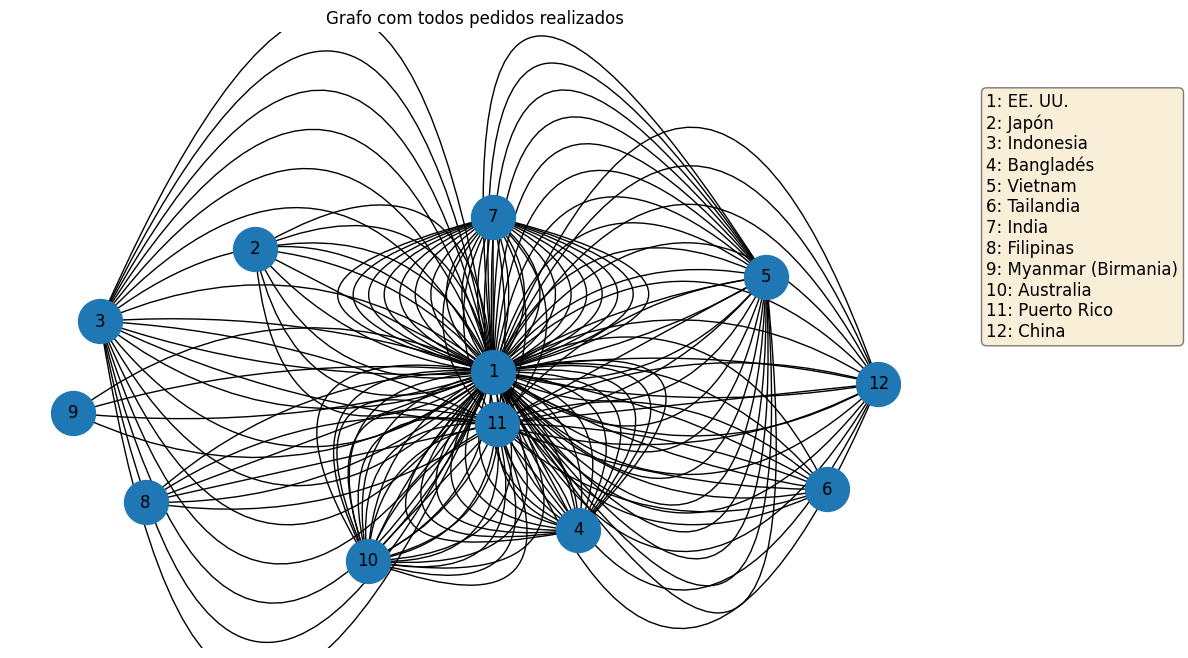

In [22]:
# É necessário sem multigrafo ao invés de um grafo direcionado.
G2 = nx.MultiDiGraph()
G2.add_edges_from(A_num)

pos2 = nx.spring_layout(G2, seed=85) # A estrutura é aleatória então fixamos uma através de seed.
plt.figure(figsize=(12, 8))

nx.draw_networkx_nodes(G2, pos2, node_size=1000)
nx.draw_networkx_labels(G2, pos2)

from collections import defaultdict
edge_counts = defaultdict(int)
for u, v, _ in G2.edges(keys=True):
    edge_counts[(u, v)] += 1

drawn_edges = defaultdict(int)

for u, v, key in G2.edges(keys=True):
    count = edge_counts[(u, v)]
    index = drawn_edges[(u, v)]
    if count == 1:
        rad = 0.0 
    else:
        rad = (index - (count - 1) / 2) * 0.2
    nx.draw_networkx_edges(G2, pos2, edgelist=[(u, v)],
                           connectionstyle=f'arc3,rad={rad}', arrows=True)
    drawn_edges[(u, v)] += 1

legend_text = "\n".join([
    f"{row['Código']}: {row['País']}"
    for _, row in df_mapping.sort_values('Código').iterrows()
])
plt.text(1.05, 0.7, legend_text, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='center', bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))

plt.title("Grafo com todos pedidos realizados")
plt.axis('off')
plt.show()


In [23]:
# Filtragem dos estados
usa_df = same_date[same_date['Customer Country'] == 'EE. UU.']
puert_df = same_date[same_date['Customer Country'] == 'Puerto Rico']
usa_df['Customer State'].to_frame()

,Customer State
2206,MA
2274,CA
2321,FL
4300,IL
4315,IL
...,...
180443,AZ
180444,NY
180445,OH
180446,FL


In [24]:
new_A = A_num
for i in usa_df['Customer State']:
    new_A.append((i, 1))
    
new_A[-5:]

[('AZ', 1), ('NY', 1), ('OH', 1), ('FL', 1), ('CA', 1)]

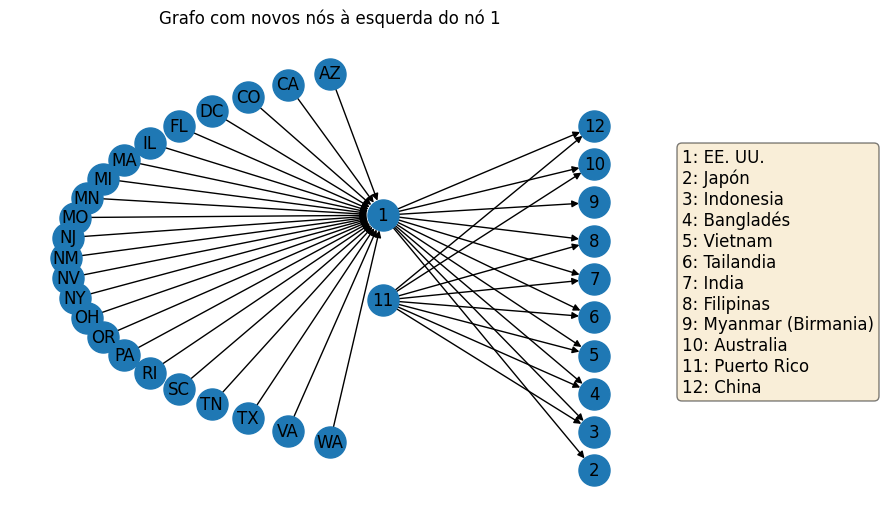

In [94]:
# # G2 = nx.DiGraph()
# G3 = nx.DiGraph()
# G3.add_edges_from(new_A)

# pos2 = nx.shell_layout(G3)
# nx.draw_shell(G3, with_labels=True, node_size=1000)


# legend_text = "\n".join([f"{row['Código']}: {row['País']}" for _, row in df_mapping.sort_values('Código').iterrows()])
# plt.text(1.05, 0.7, legend_text, transform=plt.gca().transAxes, fontsize=12,
#          verticalalignment='center', bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
# plt.title("Grafo entre pedidos e clientes")
# plt.show()


G3 = nx.DiGraph()
G3.add_edges_from(new_A)

nodes = set(G3.nodes())
left_nodes = {u for u, v in new_A if v == 1}
right_nodes = {v for u, v in new_A if u == 1}  
center_node = 1
others = nodes - left_nodes - right_nodes - {center_node}

pos = {}
pos[center_node] = (0, 6)

start_angle = 2 * np.pi / 3
end_angle = 4 * np.pi / 3
n_left = len(left_nodes)
radius = 5

for i, node in enumerate(sorted(left_nodes)):
    angle = start_angle + i * (end_angle - start_angle) / (n_left - 1 if n_left > 1 else 1)
    x = radius * np.cos(angle)
    y = radius * np.sin(angle)
    pos[node] = (x+2, y+5)


for i, node in enumerate(sorted(right_nodes)):
    pos[node] = (2, i * 0.9)

for i, node in enumerate(sorted(others)):
    pos[node] = (0, 4 - i)

# plt.figure(figsize=(12, 8))
nx.draw(G3, pos, with_labels=True, node_size=500, arrows=True)

legend_text = "\n".join([f"{row['Código']}: {row['País']}" for _, row in df_mapping.sort_values('Código').iterrows()])
plt.text(1.05, 0.5, legend_text, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='center', bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))

plt.title("Grafo com novos nós à esquerda do nó 1")
plt.axis("off")
plt.show()

In [26]:
# Ao invés de utilizar o nome do país vamos utilizar um valor numérico
us_cities = pd.unique(same_date[['Customer Country', 'Order Country']].values.ravel())
us_mapping = {city: i+1 for i, city in enumerate(us_cities)}
A_num = list(zip(
    same_date['Customer Country'].map(us_mapping),
    same_date['Order Country'].map(us_mapping)
))
A_num[:5]

[(1, 2), (1, 3), (1, 4), (1, 5), (1, 5)]

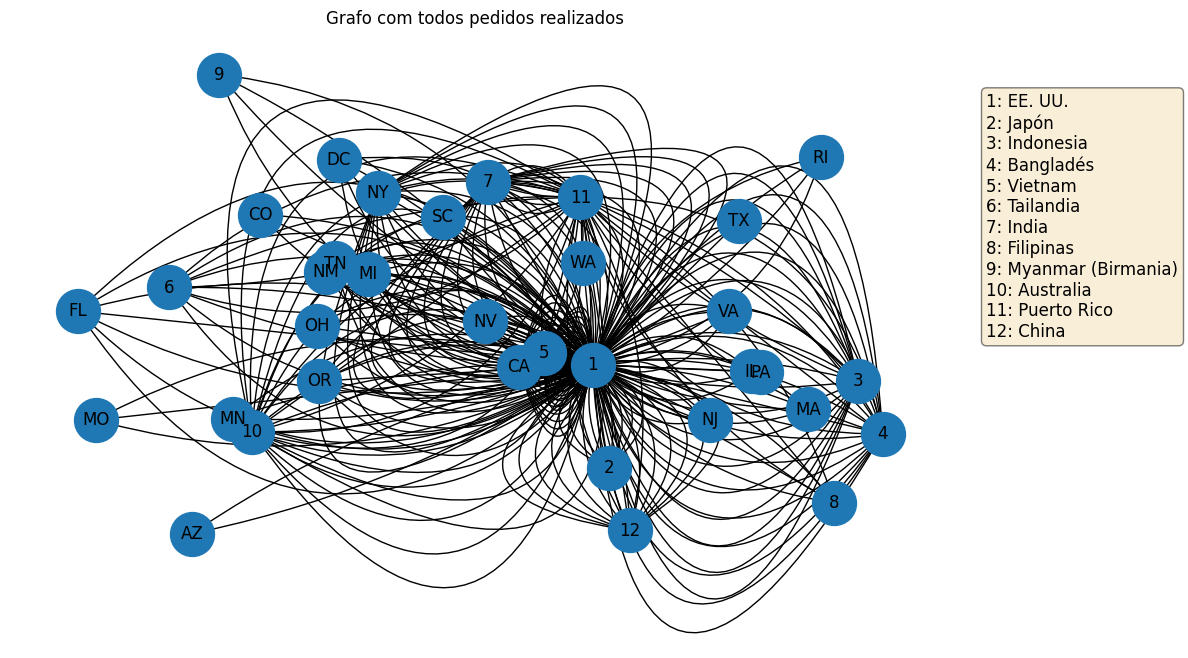

In [68]:
# É necessário sem multigrafo ao invés de um grafo direcionado.
G4 = nx.MultiDiGraph()
G4.add_edges_from(new_A)

pos2 = nx.random_layout(G4, seed=30) # A estrutura é aleatória então fixamos uma através de seed.
plt.figure(figsize=(12, 8))

nx.draw_networkx_nodes(G4, pos2, node_size=1000)
nx.draw_networkx_labels(G4, pos2)

from collections import defaultdict
edge_counts = defaultdict(int)
for u, v, _ in G4.edges(keys=True):
    edge_counts[(u, v)] += 1

drawn_edges = defaultdict(int)

for u, v, key in G4.edges(keys=True):
    count = edge_counts[(u, v)]
    index = drawn_edges[(u, v)]
    if count == 1:
        rad = 0.0 
    else:
        rad = (index - (count - 1) / 2) * 0.2
    nx.draw_networkx_edges(G4, pos2, edgelist=[(u, v)],
                           connectionstyle=f'arc3,rad={rad}', arrows=True)
    drawn_edges[(u, v)] += 1

legend_text = "\n".join([
    f"{row['Código']}: {row['País']}"
    for _, row in df_mapping.sort_values('Código').iterrows()
])
plt.text(1.05, 0.7, legend_text, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='center', bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))

plt.title("Grafo com todos pedidos realizados")
plt.axis('off')
plt.show()


In [76]:
A = list(zip(usa_df['Customer City'], same_date['Customer State']))
A[:5]

[('Quincy', 'MA'),
 ('Long Beach', 'CA'),
 ('Hialeah', 'FL'),
 ('Mchenry', 'IL'),
 ('Mchenry', 'IL')]

In [95]:
# Ao invés de utilizar o nome do país vamos utilizar um valor numérico
city_state = pd.unique(usa_df[['Customer City', 'Order State']].values.ravel())
mapping_city = {city: 'C' + str(i+1) for i, city in enumerate(city_state)}
A_us_city = list(zip(
    usa_df['Customer City'].map(mapping),
    same_date['Customer State']
))
A_us_city[:5]

[('C1', 'MA'), ('C3', 'CA'), ('C5', 'FL'), ('C7', 'IL'), ('C7', 'IL')]

In [131]:
df_cities = pd.DataFrame(list(mapping_city.items()), columns=['Cidade', 'Código'])
df_cities.head()

,Cidade,Código
0,Quincy,C1
1,Hyogo,C2
2,Long Beach,C3
3,Yakarta,C4
4,Hialeah,C5


In [101]:
complete_graph = new_A + A_us_city
complete_graph[-5:]

[('C27', 'NV'), ('C33', 'OR'), ('C47', 'NY'), ('C41', 'PR'), ('C44', 'CA')]

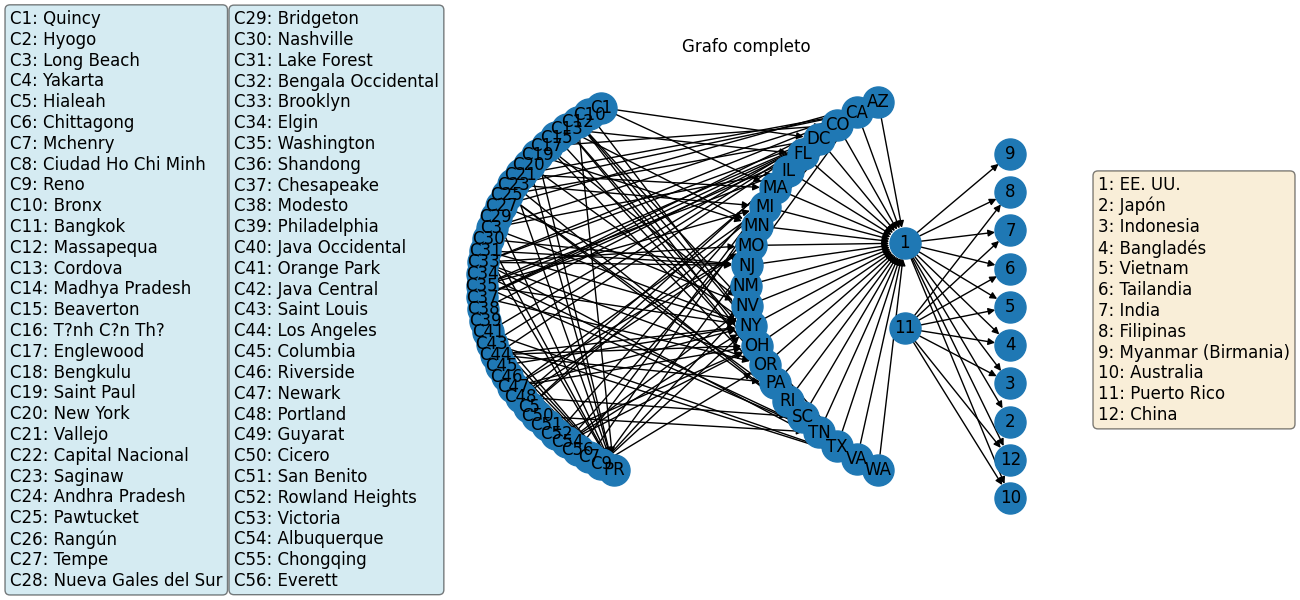

In [ ]:
G3 = nx.DiGraph()
G3.add_edges_from(complete_graph)

nodes = set(G3.nodes())
left_nodes = {u for u, v in complete_graph if v == 1}
right_nodes = {v for u, v in complete_graph if u == 1}  
center_node = 1
others = nodes - left_nodes - right_nodes - {center_node}

pos = {}
pos[center_node] = (0, 6)

start_angle = 2 * np.pi / 3
end_angle = 4 * np.pi / 3
n_left = len(left_nodes)
radius = 5

for i, node in enumerate(sorted(left_nodes, key=str)):
    angle = start_angle + i * (end_angle - start_angle) / (n_left - 1 if n_left > 1 else 1)
    x = radius * np.cos(angle)
    y = radius * np.sin(angle)
    pos[node] = (x+2, y+5)


for i, node in enumerate(sorted(right_nodes, key=str)):
    pos[node] = (2, i * 0.9)
        
n_cities = len(others)
radius = 5
for i, node in enumerate(sorted(others, key=str)):
    if node == 11:
        pos[node] = (0, 4 - i)
    else:
        angle = start_angle + i * (end_angle - start_angle) / (n_cities - 1 if n_cities > 1 else 1)
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        pos[node] = (x-3, y+5)

# plt.figure(figsize=(12, 8))
nx.draw(G3, pos, with_labels=True, node_size=500, arrows=True)

legend_text = "\n".join([f"{row['Código']}: {row['País']}" for _, row in df_mapping.sort_values('Código').iterrows()])
plt.text(1.05, 0.5, legend_text, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='center', bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))

half = len(df_cities) // 2 + len(df_cities) % 2  
df_left = df_cities.iloc[:half]
df_right = df_cities.iloc[half:]

legend_cities_left = "\n".join([f"{row['Código']}: {row['Cidade']}" for _, row in df_left.iterrows()])
legend_cities_right = "\n".join([f"{row['Código']}: {row['Cidade']}" for _, row in df_right.iterrows()])

plt.text(-0.65, 0.5, legend_cities_left, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='center', bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.5))

plt.text(-0.3, 0.5, legend_cities_right, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='center', bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.5))

plt.title("Grafo completo")
plt.axis("off")
plt.show()

In [155]:
for i, node in enumerate(sorted(others, key=str)):
    if node == 11:
        print(node)

11


In [177]:
complete_graph

[(1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 5),
 (1, 2),
 (1, 6),
 (1, 5),
 (1, 7),
 (1, 2),
 (1, 5),
 (1, 4),
 (1, 2),
 (1, 5),
 (1, 3),
 (1, 5),
 (1, 5),
 (1, 5),
 (1, 3),
 (1, 3),
 (1, 3),
 (1, 4),
 (1, 8),
 (1, 7),
 (1, 9),
 (1, 9),
 (1, 10),
 (11, 8),
 (11, 7),
 (11, 12),
 (11, 7),
 (11, 12),
 (11, 10),
 (11, 4),
 (1, 5),
 (1, 5),
 (1, 5),
 (1, 5),
 (1, 5),
 (1, 10),
 (1, 7),
 (1, 7),
 (1, 10),
 (1, 10),
 (1, 4),
 (1, 4),
 (1, 4),
 (1, 7),
 (1, 7),
 (1, 4),
 (1, 7),
 (1, 12),
 (11, 3),
 (1, 3),
 (1, 3),
 (1, 4),
 (1, 12),
 (1, 12),
 (1, 12),
 (1, 12),
 (11, 5),
 (11, 12),
 (11, 10),
 (1, 7),
 (1, 4),
 (1, 4),
 (1, 4),
 (1, 4),
 (11, 4),
 (1, 4),
 (1, 2),
 (11, 8),
 (1, 8),
 (11, 10),
 (11, 5),
 (1, 5),
 (1, 5),
 (1, 7),
 (11, 10),
 (1, 12),
 (1, 3),
 (1, 3),
 (1, 7),
 (1, 3),
 (1, 10),
 (1, 5),
 (1, 8),
 (1, 7),
 (1, 3),
 (1, 3),
 (1, 4),
 (1, 10),
 (1, 5),
 (1, 6),
 (1, 6),
 (1, 10),
 (1, 2),
 (1, 7),
 (1, 7),
 (1, 7),
 (1, 7),
 (1, 7),
 (1, 7),
 (1, 12),
 (1, 12),
 (11, 10),
 (11, 